**Data Science Capstone project - Retail**

Project Task: Week 1
Data Cleaning:

1. Perform a preliminary data inspection and data cleaning.

a. Check for missing data and formulate an apt strategy to treat them.

b. Remove duplicate data records.

c. Perform descriptive analytics on the given data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing data

In [ ]:
df=pd.read_excel('/Online Retail.xlsx')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


2.Data cleaning

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(401604, 8)

3.Checking & Removing duplicate values

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
df.shape

(401604, 8)

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.001243,-0.003457
UnitPrice,-0.001243,1.000000,-0.004524
CustomerID,-0.003457,-0.004524,1.000000


In [ ]:
#let's do a copy of our df for next manipulations
retail = df.copy()

4.Exploration of the data

In [ ]:
#calculate revenue per row and add new column
retail['Revenue'] = retail['Quantity'] * retail['UnitPrice']

In [ ]:
retail.InvoiceDate = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

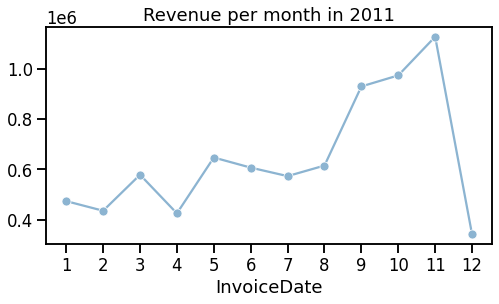

In [ ]:
# Let's visualize the top grossing months
retail_month = retail[retail.InvoiceDate.dt.year==2011]
monthly_gross = retail_month.groupby(retail_month.InvoiceDate.dt.month).Revenue.sum()

plt.figure(figsize=(8,4))
sns.set_context("talk")
sns.set_palette("PuBuGn_d")
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o')
plt.xticks(range(1,13))
plt.title("Revenue per month in 2011")
plt.show()

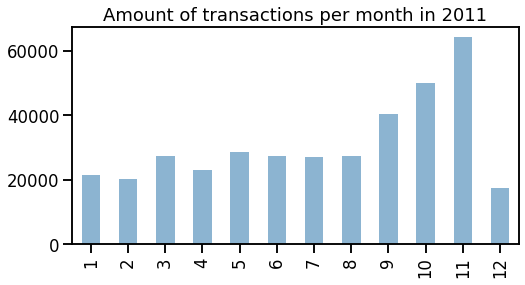

In [ ]:
#amount of transactions per month
plt.figure(figsize=(8,4))
retail[retail.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')
plt.title("Amount of transactions per month in 2011")
plt.show()

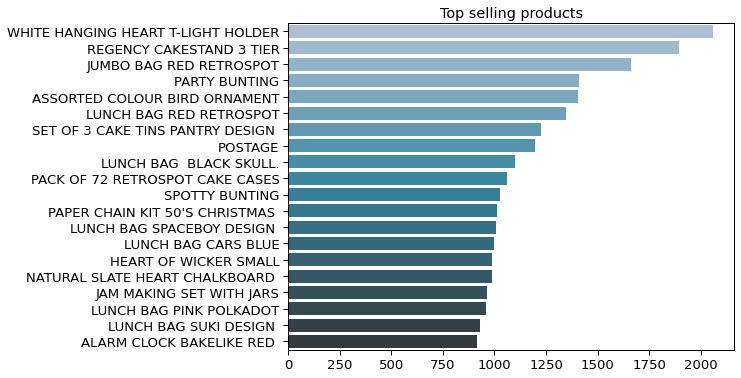

<Figure size 432x288 with 0 Axes>

In [ ]:
# Let's visualize some top products from the whole range
top_products = retail['Description'].value_counts()[:20]
plt.figure(figsize=(8,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values, 
           palette='PuBuGn_d')
plt.title("Top selling products")
plt.show()
plt.savefig('top_products.png')

Data Transformation:

2. Perform cohort analysis (a cohort is a group of subjects that share a defining characteristic). Observe how a cohort behaves across time and compare it to other cohorts.

a. Create month cohorts and analyze active customers for each cohort.

b. Analyze the retention rate of customers.

1.Cohort Analysis  


In [ ]:
import datetime as dt

In [ ]:
#creating invoice month column to see first month when customer purchased 
retail['InvoiceMonth'] = retail['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))

In [ ]:
retail.InvoiceMonth

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-01
541905   2011-12-01
541906   2011-12-01
541907   2011-12-01
541908   2011-12-01
Name: InvoiceMonth, Length: 401604, dtype: datetime64[ns]

In [ ]:
grouping = retail.groupby('CustomerID')['InvoiceMonth']
#assign smallest invoice value to each customer
retail['CohortMonth'] = grouping.transform('min')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [ ]:
#function to extract year, month, day as integers
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [ ]:
#extract month
invoice_year, invoice_month, _ = get_date_int(retail, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(retail, 'CohortMonth')

In [ ]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [ ]:
# Extract the difference in days from all previous values
retail['CohortIndex'] = years_diff * 12 + months_diff + 1
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [ ]:
#count monthly active customers from each cohort
grouping = retail.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns = 'CohortIndex', values='CustomerID')

In [ ]:
#Customer retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention = retention.round(3) * 100
retention.head(20)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


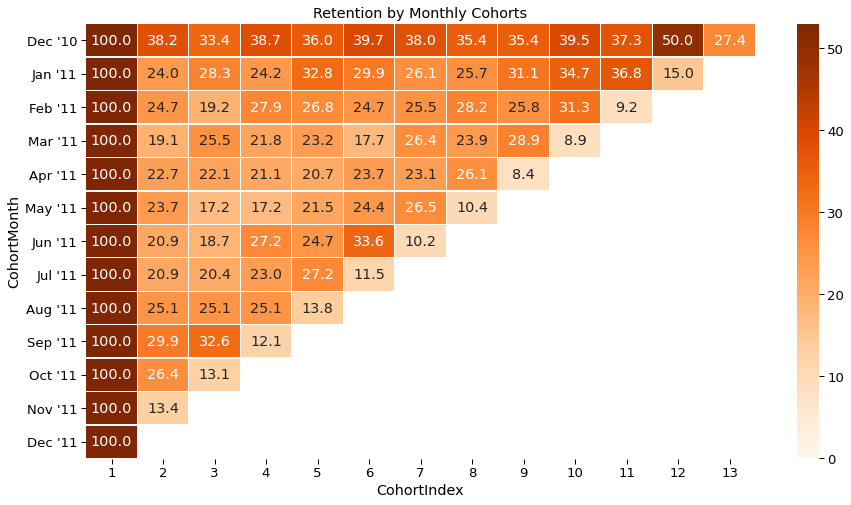

In [ ]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

plt.figure(figsize=(15,8))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(data=retention,
            annot = True,
            cmap = "Oranges",
            vmin = 0.0,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show()

Project Task: Week 2
Data Modeling : RFM analysis

2.RFM analysis

which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary)

In [ ]:
#12 months of data
print('Min:{}; Max:{}'.format(min(retail.InvoiceDate), max(retail.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [ ]:
#calculate revenue per row and add new column
retail['MonetaryValue'] = retail['Quantity'] * retail['UnitPrice']

In [ ]:
retail.MonetaryValue

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: MonetaryValue, Length: 401604, dtype: float64

In [ ]:
#let's look at amount spend per customer (revenue contributed) M-Monetary
retail_mv = retail.groupby(['CustomerID']).agg({'MonetaryValue': sum}).reset_index()
retail_mv.head()

,CustomerID,MonetaryValue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
#F-frequency (how many purchases each customer made)
retail_f = retail.groupby('CustomerID')['InvoiceNo'].count()
retail_f = retail_f.reset_index()
retail_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
#merge previous dataframes together (mv+f)
retail_mv_f = pd.merge(retail_mv, retail_f, on='CustomerID', how='inner')
retail_mv_f.head()

,CustomerID,MonetaryValue,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
#R-recency 
#last transaction date 

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(retail['InvoiceDate'])

#difference between last date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex,MonetaryValue,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,20.34,373 days 04:24:00


In [ ]:
#recency per customer (last transaction date)
retail_r = retail.groupby('CustomerID')['Diff'].min()
retail_r = retail_r.reset_index()

# Extract number of days only
retail_r['Diff'] = retail_r['Diff'].dt.days

In [ ]:
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [ ]:
#merge R dataframe with FM

retail_rfm = pd.merge(retail_mv_f, retail_r, on='CustomerID', how='inner')
retail_rfm.columns = ['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [ ]:
cols = retail_rfm.columns.tolist()
cols

['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']

In [ ]:
#changed columns order
cols = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']
retail_rfm = retail_rfm[cols]
retail_rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [ ]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(retail_rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(retail_rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(retail_rfm.MonetaryValue, q = 4, labels = m_labels)

In [ ]:
# make a new column for group labels
retail_rfm['R'] = r_groups.values
retail_rfm['F'] = f_groups.values
retail_rfm['M'] = m_groups.values
# sum up the three columns
retail_rfm['RFM_Segment'] = retail_rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
retail_rfm['RFM_Score'] = retail_rfm[['R', 'F', 'M']].sum(axis = 1)
retail_rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346.0,325,2,0.00,1,1,1,1.01.01.0,3
1,12347.0,1,182,4310.00,4,4,4,4.04.04.0,12
2,12348.0,74,31,1797.24,2,2,4,2.02.04.0,8
3,12349.0,18,73,1757.55,3,3,4,3.03.04.0,10
4,12350.0,309,17,334.40,1,1,2,1.01.02.0,4


In [ ]:
# assign labels from total score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(retail_rfm.RFM_Score, q = 4, labels = score_labels)
retail_rfm['RFM_Level'] = score_groups.values
retail_rfm.sort_values(by='RFM_Score', ascending=False)
retail_rfm.head(10)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,12346.0,325,2,0.00,1,1,1,1.01.01.0,3,Green
1,12347.0,1,182,4310.00,4,4,4,4.04.04.0,12,Gold
2,12348.0,74,31,1797.24,2,2,4,2.02.04.0,8,Silver
3,12349.0,18,73,1757.55,3,3,4,3.03.04.0,10,Silver
4,12350.0,309,17,334.40,1,1,2,1.01.02.0,4,Green
5,12352.0,35,95,1545.41,3,3,3,3.03.03.0,9,Silver
6,12353.0,203,4,89.00,1,1,1,1.01.01.0,3,Green
7,12354.0,231,58,1079.40,1,3,3,1.03.03.0,7,Bronze
8,12355.0,213,13,459.40,1,1,2,1.01.02.0,4,Green
9,12356.0,22,59,2811.43,3,3,4,3.03.04.0,10,Silver


In [ ]:
retail_rfm_levels = retail_rfm.groupby('RFM_Level')['CustomerID'].count().reset_index(name='counts')
retail_rfm_levels.head()

,RFM_Level,counts
0,Green,1298
1,Bronze,908
2,Silver,1322
3,Gold,844


In [ ]:
#let's try to do more detailed segmentation
segment_dict = {    
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [ ]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

# Allocate segments to each customer as per the RFM score mapping
retail_rfm['Segment'] = retail_rfm.RFM_Segment.map(lambda x: dict_segment.get(x))

In [ ]:
# Allocate all remaining customers to others segment category
retail_rfm.Segment.fillna('others', inplace=True)

In [ ]:
retail_rfm.sample(10)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment
3351,16881.0,66,1,432.00,2,1,2,2.01.02.0,5,Green,others
570,13091.0,20,24,319.82,3,2,2,3.02.02.0,7,Bronze,others
4132,17958.0,116,7,508.46,2,1,2,2.01.02.0,5,Green,others
1790,14764.0,43,7,250.55,3,1,1,3.01.01.0,5,Green,others
1269,14052.0,19,56,225.36,3,3,1,3.03.01.0,7,Bronze,others
1597,14503.0,2,164,3543.26,4,4,4,4.04.04.0,12,Gold,others
3602,17234.0,182,14,149.89,1,1,1,1.01.01.0,3,Green,others
465,12940.0,45,100,862.44,3,4,3,3.04.03.0,10,Silver,others
1851,14854.0,77,130,2730.09,2,4,4,2.04.04.0,10,Silver,others
3428,16985.0,16,121,5461.62,4,4,4,4.04.04.0,12,Gold,others


In [ ]:
retail_rfm_segments = retail_rfm[retail_rfm.Segment!='other'].groupby('Segment')['CustomerID'].count().reset_index(name='counts')
retail_rfm_segments.iloc[:8]

,Segment,counts
0,others,4372


In [ ]:
retail_rfm_levels

,RFM_Level,counts
0,Green,1298
1,Bronze,908
2,Silver,1322
3,Gold,844


Project Task: Week 3
Data Modeling :
Create clusters using k-means clustering algorithm.

3.k-Means Clustering

In [ ]:
# copying the data into new variable
df_kmeans = retail_rfm.copy()
# taking only relevant columns
df_kmeans = df_kmeans.iloc[:,:4]
df_kmeans.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


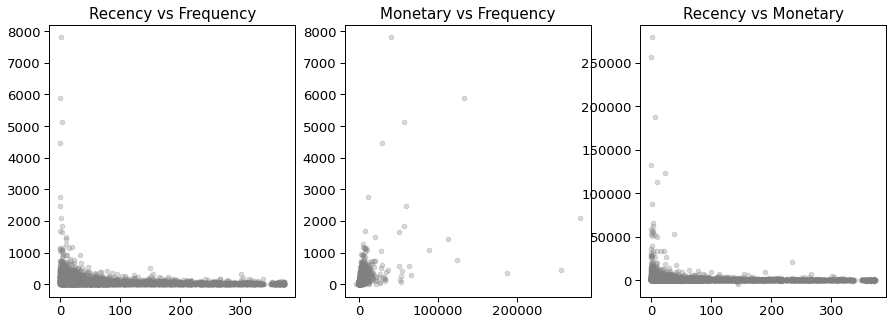

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df_kmeans.Recency, df_kmeans.Frequency, color='grey', alpha=0.3)
plt.title('Recency vs Frequency', size=15)
plt.subplot(1,3,2)
plt.scatter(df_kmeans.MonetaryValue, df_kmeans.Frequency, color='grey', alpha=0.3)
plt.title('Monetary vs Frequency', size=15)
plt.subplot(1,3,3)
plt.scatter(df_kmeans.Recency, df_kmeans.MonetaryValue, color='grey', alpha=0.3)
plt.title('Recency vs Monetary', size=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


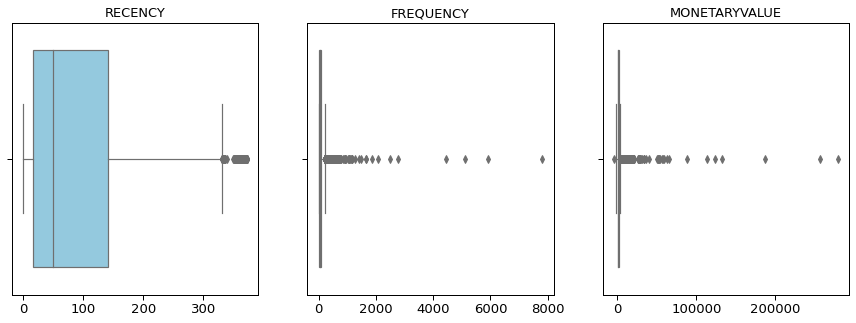

In [ ]:
# checking the distribution of the variables

column = ['Recency','Frequency','MonetaryValue']
plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(df_kmeans[j], color='skyblue')
    plt.xlabel('')
    plt.title('{}'.format(j.upper()), size=13)
plt.show()

In [ ]:
# Removing outliers for Monetary
Q1 = df_kmeans.MonetaryValue.quantile(0.05)
Q3 = df_kmeans.MonetaryValue.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.MonetaryValue >= Q1 - 1.5*IQR) & (df_kmeans.MonetaryValue <= Q3 + 1.5*IQR)]

# Removing outliers for Recency
Q1 = df_kmeans.Recency.quantile(0.05)
Q3 = df_kmeans.Recency.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.Recency >= Q1 - 1.5*IQR) & (df_kmeans.Recency <= Q3 + 1.5*IQR)]

# Removing outliers for Frequency
Q1 = df_kmeans.Frequency.quantile(0.05)
Q3 = df_kmeans.Frequency.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.Frequency >= Q1 - 1.5*IQR) & (df_kmeans.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
# resetting the index
df_kmeans = df_kmeans.reset_index(drop=True)
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4295 non-null   float64
 1   Recency        4295 non-null   int64  
 2   Frequency      4295 non-null   int64  
 3   MonetaryValue  4295 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 134.3 KB


In [ ]:
# looking at random 5 rows
df_kmeans.sample(5)

,CustomerID,Recency,Frequency,MonetaryValue
3151,16696.0,134,10,657.90
1661,14632.0,262,8,114.56
4065,17968.0,373,81,265.10
2091,15234.0,276,14,197.00
4077,17984.0,144,48,152.68


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# removing customer id as it will not used in making cluster
df_kmeans=df_kmeans.drop(['CustomerID'],axis=1)

KeyError: ignored

In [ ]:
df_kmeans.head()

,Recency,Frequency,MonetaryValue
0,325,2,0.00
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [ ]:
# scaling the variables and store it in different df
standard_scaler = StandardScaler()
df_kmeans_norm = standard_scaler.fit_transform(df_kmeans)

# converting it into dataframe
df_kmeans_norm = pd.DataFrame(df_kmeans_norm)
df_kmeans_norm.columns = ['Recency','Frequency','MonetaryValue']
df_kmeans_norm.head()

,Recency,Frequency,MonetaryValue
0,2.302166,-0.750830,-0.722542
1,-0.906150,1.057112,1.735232
2,-0.183289,-0.459551,0.302333
3,-0.737813,-0.037698,0.279700
4,2.143731,-0.600168,-0.531850


Initially without any knowledge we are clustering the data into 5 clusters. The only intution to do is as in RFM we categorize the data into 5 categories.
Later we look different methods to decide the optimal value for k.

In [ ]:
!pip3 install KMeans

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn import cluster

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Kmeans with K=5

model_clus5 = KMeans(n_clusters = 5)
model_clus5.fit(df_kmeans_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# checking the labels
model_clus5.labels_

array([2, 3, 1, ..., 1, 0, 1], dtype=int32)

In [ ]:
df_kmeans['clusters'] = model_clus5.labels_
df_kmeans.head()

,Recency,Frequency,MonetaryValue,clusters
0,325,2,0.00,2
1,1,182,4310.00,3
2,74,31,1797.24,1
3,18,73,1757.55,1
4,309,17,334.40,2


In [ ]:
df_kmeans.groupby('clusters').mean().round(0)

,Recency,Frequency,MonetaryValue
clusters,,,
0,19.0,381.0,4018.0
1,50.0,40.0,633.0
2,252.0,25.0,387.0
3,30.0,144.0,2497.0
4,20.0,297.0,9332.0


Finding the Optimal Number of Clusters

Elbow Curve to get the right number of Clusters

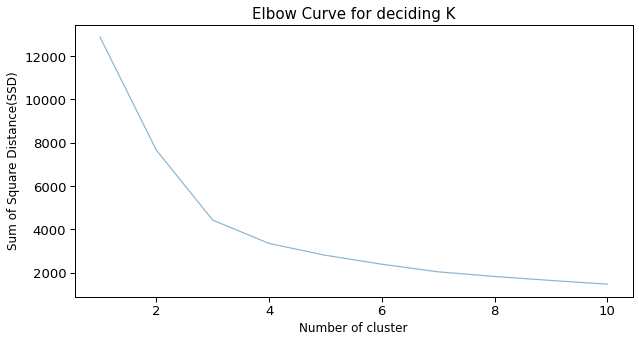

In [ ]:
# Elbow-curve/SSD

ssd = []
for num_clusters in list(range(1,11)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmeans_norm)
    ssd.append(model_clus.inertia_)
    
# plot the SSDs for each n_clusters
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,11,1), ssd)
plt.xlabel('Number of cluster', size=12)
plt.ylabel('Sum of Square Distance(SSD)', size=12)
plt.title('Elbow Curve for deciding K', size=15)
plt.show()

In [ ]:
# Silhouette analysis

for num_clusters in list(range(2,11)):
    # intialise kmeans
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmeans_norm)
    
    cluster_labels = model_clus.labels_


In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
 # silhouette score
silhouette_avg = silhouette_score(df_kmeans_norm, cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=10, the silhouette score is 0.3814908101545369


From the elbow curve we observe the elbow at cluster 3 and cluster 4.
Also from Silhouette analysis we see the value is better when number of cluster will be 3 rather than 4.
So we now categorize the data into 3 clusters and check their RFM values and its distribution.

In [ ]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3)
model_clus3.fit(df_kmeans_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
df_kmeans['clusters'] = model_clus3.labels_
df_kmeans.head()

,Recency,Frequency,MonetaryValue,clusters
0,325,2,0.00,0
1,1,182,4310.00,2
2,74,31,1797.24,1
3,18,73,1757.55,1
4,309,17,334.40,0


In [ ]:
df_kmeans.groupby('clusters').mean().round(0)

,Recency,Frequency,MonetaryValue
clusters,,,
0,248.0,25.0,387.0
1,44.0,59.0,948.0
2,22.0,285.0,4901.0


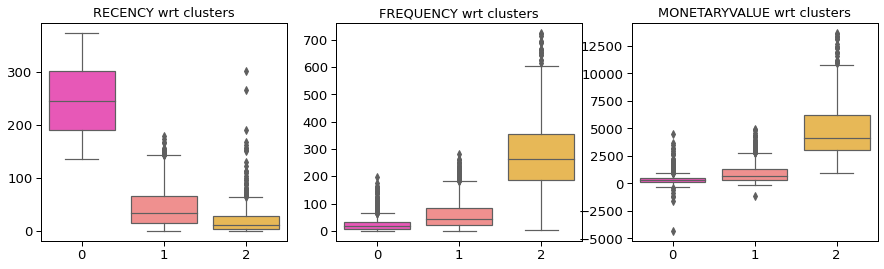

In [ ]:
column = ['Recency','Frequency','MonetaryValue']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df_kmeans[j], x=df_kmeans['clusters'], palette='spring')
    plt.title('{} wrt clusters'.format(j.upper()), size=13)
    plt.ylabel('')
    plt.xlabel('')

plt.show()

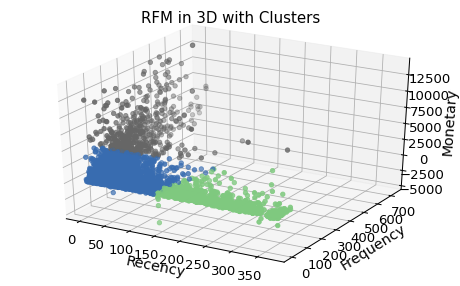

In [ ]:
# Creating figure
fig = plt.figure(figsize = (8, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(df_kmeans.Recency, df_kmeans.Frequency, df_kmeans.MonetaryValue, c=df_kmeans.clusters, cmap='Accent')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM in 3D with Clusters', size=15)
ax.set(facecolor='white')
plt.show()

Observations:
In the above 3D graph, I put all the three variable into 3 axis and added the cluster variable to differentiate the points.
Grey points is the group of customers whose Recency is high, Frequency is low and Monetary value is also low.
Green points are the group of customers whose Recency is low, Frequency is better than grey ones and Monetary is good.
Blue points are the group of customers whose Recency is low(that is good), Frequency is better than the other two and Monetary is high.